In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sys import path, platform

## Set project root
if platform == "linux" or platform == "linux2":
    root_dir = "/mnt/synapse/projects/SlotsTasks/online/prolific-food-craving/"
    model_functions_path = f"{root_dir}/derivatives/decision/"
elif platform == "darwin":
    root_dir = "/Volumes/synapse/projects/SlotsTasks/online/prolific-food-craving/"
    model_functions_path = f"{root_dir}/derivatives/decision/"
elif platform == "win32":
    root_dir = "Z:\\synapse\\projects\\SlotTasks\\online\\prolific-food-craving\\"
    model_functions_path = f"{root_dir}\\derivatives\\decision\\"

## Add model_functions to system path
path.append(model_functions_path)


from utils import load_data, plotting
from bayesian_model_functions import RescorlaWagner, Biased, Heuristic, RWRL, RWDecay


In [61]:
# Graphing libraries
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
pd.options.plotting.backend = "matplotlib"

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# Stats libraries
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm

## Load data

In [3]:
path_to_summary = f'{root_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{root_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
# df_summary

In [4]:
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
df_summary.shape

(43, 10)

In [5]:
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
longform.loc[(longform['Craving Rating']>-1)&(longform['Trial']==36)] = -1
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Optimal choice calculation

In [33]:
fig = px.box(
    data_frame=df_summary, 
    y=['Money Accuracy', 'Other Accuracy'], 
    height=400, width=700, 
    points='all',
    title='Run 1 Accuracy'
)
fig.add_hline(y=0.5)
fig.show()

## Plot choices

In [34]:
chosen_longform = longform
fig1 = go.Figure()
for y, pid in enumerate(chosen_longform['PID'].unique()):
    money_choices = chosen_longform[(chosen_longform['PID']==pid)&(chosen_longform['Type']=='money')]['Action']
    right_index = money_choices.astype(bool)
    left_index = right_index == False
    right_choices = np.arange(len(money_choices))[right_index]
    left_choices = np.arange(len(money_choices))[left_index]

    fig1.add_trace(
        go.Scatter(
            x=right_choices,
            y=[y] * len(right_choices),
            mode="markers",
            showlegend=False,
            marker=dict(
                color="cornflowerblue", symbol="triangle-right", size=12
            ),
        )
    )

    fig1.add_trace(
        go.Scatter(
            x=left_choices,
            y=[y] * len(left_choices),
            mode="markers",
            showlegend=False,
            marker=dict(color="orange", symbol="triangle-left", size=11),
        )
    )
    height, width = (500, 500)
    fig1.update_layout(
        title="Money Block Choices", autosize=False, width=width, height=height,
    )
fig1.show()

fig2 = go.Figure()
for y, pid in enumerate(chosen_longform['PID'].unique()):
    other_choices = chosen_longform[(chosen_longform['PID']==pid)&(chosen_longform['Type']=='other')]['Action']
    right_index = other_choices.astype(bool)
    left_index = right_index == False
    right_choices = np.arange(len(other_choices))[right_index]
    left_choices = np.arange(len(other_choices))[left_index]

    fig2.add_trace(
        go.Scatter(
            x=right_choices,
            y=[y] * len(right_choices),
            mode="markers",
            showlegend=False,
            marker=dict(
                color="cornflowerblue", symbol="triangle-right", size=12
            ),
        )
    )

    fig2.add_trace(
        go.Scatter(
            x=left_choices,
            y=[y] * len(left_choices),
            mode="markers",
            showlegend=False,
            marker=dict(color="orange", symbol="triangle-left", size=11),
        )
    )
    height, width = (500, 500)
    fig2.update_layout(
        title="Other Block Choices", autosize=False, width=width, height=height,
    )
fig2.show()
    

## Model-free metrics

### Overall distributions of craving and mood ratings

In [35]:
craving_ratings = longform[longform['Craving Rating']>-1]['Craving Rating'].to_numpy()
keys, vals = np.unique(craving_ratings, return_counts=True)
fig = px.bar(x=keys, y=vals, 
    labels={
        'x': 'Rating',
        'y': 'Frequency'
    },
    height=400, width=800,
    title = 'Craving Rating Distribution',
    color=np.linspace(0,1,len(vals)),
    color_continuous_scale=px.colors.sequential.Magma
)
fig.show()

In [36]:
mood_ratings = longform[longform['Mood Rating']>-1]['Mood Rating'].to_numpy()
keys, vals = np.unique(mood_ratings, return_counts=True)
px.bar(x=keys, y=vals, 
    labels={
        'x': 'Rating',
        'y': 'Frequency'
    },
    height=400, width=800,
    title = 'Mood Rating Distribution',
    color=np.linspace(0,1,len(vals)),
    color_continuous_scale=px.colors.sequential.Magma
)

### Craving by condition

In [58]:
money_fast = longform[
    (longform['Craving Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='money')
]['Craving Rating'].to_numpy()

money_slow = longform[
    (longform['Craving Rating']>-1) & 
    (longform['Spin Speed']=='slow') & 
    (longform['Type']=='money')
]['Craving Rating'].to_numpy()

other_fast = longform[
    (longform['Craving Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='other')
]['Craving Rating'].to_numpy()

other_slow = longform[
    (longform['Craving Rating']>-1) & 
    (longform['Spin Speed']=='slow') & 
    (longform['Type']=='other')
]['Craving Rating'].to_numpy()

In [59]:
fig = go.Figure()
x_names = ['Fast'] * len(money_fast) + ['Slow'] * len(money_slow)
fig.add_trace(go.Box(
    y = np.hstack([money_fast, money_slow]),
    x = x_names,
    boxpoints='all',
    pointpos=0,
    name='Money',
))
fig.add_trace(go.Box(
    y = np.hstack([other_fast, other_slow]),
    x = x_names,
    boxpoints='all',
    pointpos=0,
    name='Other'
))
fig.update_layout(
    height=500, width=800,
    boxmode='group',
)
fig.show()

In [70]:
print('Within block by speed')
print(f'Money, fast vs. slow: {stats.ttest_ind(money_fast, money_slow)[1].round(3)}')
print(f'Other, fast vs. slow: {stats.ttest_ind(other_fast, other_slow)[1].round(3)}')
print('\nAcross block by speed')
print(f'Fast, money vs. other: {stats.ttest_ind(money_fast, other_fast)[1].round(3)}')
print(f'Slow, money vs. other: {stats.ttest_ind(money_slow, other_slow)[1].round(3)}')
print('\nBy speed only')
print(f'Fast vs. slow, money+other: {stats.ttest_ind(np.hstack([money_fast, other_fast]), np.hstack([money_slow, other_slow]))[1].round(3)}')
print('\nBy block only')
print(f'Money vs. Other, fast+slow: {stats.ttest_ind(np.hstack([money_fast, money_slow]), np.hstack([other_fast, other_slow]))[1].round(3)}')

Within block by speed
Money, fast vs. slow: 0.933
Other, fast vs. slow: 0.695

Across block by speed
Fast, money vs. other: 0.001
Slow, money vs. other: 0.001

By speed only
Fast vs. slow, money+other: 0.841

By block only
Money vs. Other, fast+slow: 0.0


### Mood by condition

In [50]:
money_fast_mood = longform[
    (longform['Mood Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='money')
]['Mood Rating'].to_numpy()

money_slow_mood = longform[
    (longform['Mood Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='money')
]['Mood Rating'].to_numpy()

other_fast_mood = longform[
    (longform['Mood Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='other')
]['Mood Rating'].to_numpy()

other_slow_mood = longform[
    (longform['Mood Rating']>-1) & 
    (longform['Spin Speed']=='fast') & 
    (longform['Type']=='other')
]['Mood Rating'].to_numpy()

In [55]:
fig = go.Figure()
x_names_mood = ['Fast'] * len(money_fast_mood) + ['Slow'] * len(money_slow_mood)
fig.add_trace(go.Box(
    y = np.hstack([money_fast_mood, money_slow_mood]),
    x = x_names_mood,
    boxpoints='all',
    pointpos=0,
    name='Money',
))
fig.add_trace(go.Box(
    y = np.hstack([other_fast_mood, other_slow_mood]),
    x = x_names_mood,
    boxpoints='all',
    pointpos=0,
    name='Other'
))
fig.update_layout(
    height=500, width=800,
    boxmode='group',
)
fig.show()

In [71]:
print('Within block by speed')
print(f'Money, fast vs. slow: {stats.ttest_ind(money_fast_mood, money_slow_mood)[1].round(3)}')
print(f'Other, fast vs. slow: {stats.ttest_ind(other_fast_mood, other_slow_mood)[1].round(3)}')
print('\nAcross block by speed')
print(f'Fast, money vs. other: {stats.ttest_ind(money_fast_mood, other_fast_mood)[1].round(3)}')
print(f'Slow, money vs. other: {stats.ttest_ind(money_slow_mood, other_slow_mood)[1].round(3)}')
print('\nBy speed only')
print(f'Fast vs. slow, money+other: {stats.ttest_ind(np.hstack([money_fast_mood, other_fast_mood]), np.hstack([money_slow_mood, other_slow_mood]))[1].round(3)}')
print('\nBy block only')
print(f'Money vs. Other, fast+slow: {stats.ttest_ind(np.hstack([money_fast_mood, money_slow_mood]), np.hstack([other_fast_mood, other_slow_mood]))[1].round(3)}')

Within block by speed
Money, fast vs. slow: 1.0
Other, fast vs. slow: 1.0

Across block by speed
Fast, money vs. other: 0.95
Slow, money vs. other: 0.95

By speed only
Fast vs. slow, money+other: 1.0

By block only
Money vs. Other, fast+slow: 0.929


### 3-way ANOVA (speed, block, PE)

In [6]:
decision_model_path = f'{root_dir}/derivatives/decision/output/'
decision_model_name = 'rw'
q_longform = pd.read_csv(f'{decision_model_path}/{decision_model_name}/longform.csv')
q_df_summary = pd.read_csv(f'{decision_model_path}/{decision_model_name}/summary.csv')
q_longform.loc[(q_longform['Craving Rating']>-1)&(q_longform['Trial']==36)] = -1

In [18]:
data = q_longform[(q_longform['Craving Rating']>-1)].copy()
data['PESign'] = (data['PE'] > 0)
data

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db,Q_left,Q_right,PE,PESign
1,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1,0.500000,0.204891,-0.884128,False
4,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1,0.047482,0.204891,-0.204891,False
8,61281debe85082cc937dd9ae,14,1,other,9,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.168,slow,30.0,-1.0,1,0.810107,0.047482,0.819412,True
12,61281debe85082cc937dd9ae,18,1,other,13,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.321,fast,32.0,31.0,1,0.810107,0.228996,-0.988145,False
16,61281debe85082cc937dd9ae,22,1,other,17,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.052,slow,28.0,20.0,1,0.811764,0.012298,0.812263,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,6102d5e6ff92a8dd0cce6b8f,5693,2,other,49,1.648471e+09,0,1.648471e+09,0,1.648471e+09,0.536,fast,13.0,12.0,47,0.189148,0.035118,-0.994427,False
5390,6102d5e6ff92a8dd0cce6b8f,5695,2,other,51,1.648471e+09,0,1.648471e+09,0,1.648471e+09,0.369,slow,18.0,16.0,47,0.160872,0.035118,-0.845769,False
5393,6102d5e6ff92a8dd0cce6b8f,5698,2,other,54,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.452,slow,16.0,8.0,47,0.030599,0.965091,0.183529,True
5394,6102d5e6ff92a8dd0cce6b8f,5699,2,other,55,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.820,fast,12.0,-1.0,47,0.030599,0.993360,0.034909,True


<AxesSubplot:title={'center':'Craving Rating'}, xlabel='[Type, Spin Speed, PESign]'>

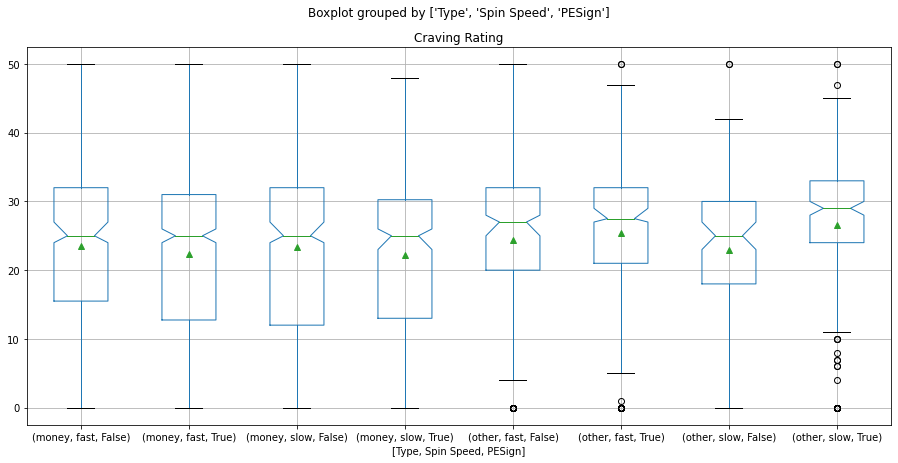

In [68]:
data.boxplot(
    column='Craving Rating', 
    by=['Type', 'Spin Speed', 'PESign'], 
    figsize=(15,7),
    showmeans=True,
    notch=True,
    bootstrap=10000,
)

In [65]:
# formula = 'Q("Craving Rating") ~ C(PESign, Sum) + C(Type, Sum) + C(PESign, Sum)*C(Q("Spin Speed"), Sum)*C(Type, Sum)'
formula = 'Q("Craving Rating") ~ C(Type, Sum) + C(PESign, Sum)*C(Type, Sum)'
model = ols(formula, data=data).fit()
# model = mixedlm(formula, data=data, groups=['PID']).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
"C(Type, Sum)",1.0,2429.045000,2429.045000,17.490009,0.000030
"C(PESign, Sum)",1.0,126.514735,126.514735,0.910952,0.339990
"C(PESign, Sum):C(Type, Sum)",1.0,1184.779764,1184.779764,8.530846,0.003535
Residual,1796.0,249431.815502,138.881857,NaN,NaN


In [78]:
stats.ttest_ind(
    data[data['Type']=='money']['Craving Rating'], 
    data[data['Type']=='other']['Craving Rating']
)
print('Money v Other\t', stats.ttest_ind(
    data[(data['Type']=='money')]['Craving Rating'], 
    data[(data['Type']=='other')]['Craving Rating']
)[1].round(8))

Money v Other	 3.143e-05


In [79]:
print('+PE\t:\tMoney v Other\t', stats.ttest_ind(
    data[(data['Type']=='money')&(data['PESign']==True)]['Craving Rating'], 
    data[(data['Type']=='other')&(data['PESign']==True)]['Craving Rating']
)[1].round(8))
print('-PE\t:\tMoney v Other\t', stats.ttest_ind(
    data[(data['Type']=='money')&(data['PESign']==False)]['Craving Rating'], 
    data[(data['Type']=='other')&(data['PESign']==False)]['Craving Rating']
)[1].round(8))
print('Money\t:\t+PE v -PE\t', stats.ttest_ind(
    data[(data['Type']=='money')&(data['PESign']==True)]['Craving Rating'], 
    data[(data['Type']=='money')&(data['PESign']==False)]['Craving Rating']
)[1].round(8))
print('Other\t:\t+PE v -PE\t', stats.ttest_ind(
    data[(data['Type']=='other')&(data['PESign']==True)]['Craving Rating'], 
    data[(data['Type']=='other')&(data['PESign']==False)]['Craving Rating']
)[1].round(8))

+PE	:	Money v Other	 2.2e-07
-PE	:	Money v Other	 0.65996068
Money	:	+PE v -PE	 0.18652037
Other	:	+PE v -PE	 0.00390755


<AxesSubplot:title={'center':'Craving Rating'}, xlabel='[Type, PESign]'>

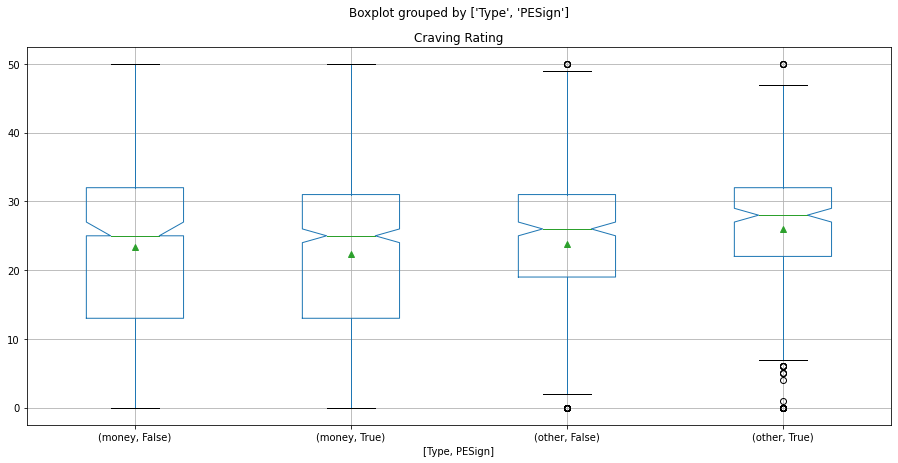

In [67]:
data.boxplot(
    column='Craving Rating', 
    by=['Type', 'PESign'], 
    figsize=(15,7),
    showmeans=True,
    notch=True,
    bootstrap=10000
)

# Archive

### 3 factors (PE, block, speed) individual t-tests

In [151]:
def plot_craving_box(split_cravings_, title):
    fig = go.Figure()

    for k in split_cravings_.keys():
        fig.add_trace(go.Box(
            y = split_cravings_[k],
            x = [str(k)] * len(split_cravings_[k]),
            boxpoints='all',
            pointpos=0,
            name=str(k)
        ))
        print(f'{k}: mean={np.mean(split_cravings_[k]).round(3)}, std={np.std(split_cravings_[k]).round(3)}')
    fig.update_layout(
        height=500, width=800,
        title=title,
    )
    return fig

In [152]:
def combine(tag, split_cravings_):
    if tag=='block':
        combined = {}
        combined[('fast', 'positive')] = np.hstack([
            split_cravings_[('fast', 'money', 'positive')],
            split_cravings_[('fast', 'other', 'positive')]
        ])
        combined[('slow', 'positive')] = np.hstack([
            split_cravings_[('slow', 'money', 'positive')],
            split_cravings_[('slow', 'other', 'positive')]
        ])
        combined[('fast', 'negative')] = np.hstack([
            split_cravings_[('fast', 'money', 'negative')],
            split_cravings_[('fast', 'other', 'negative')]
        ])
        combined[('slow', 'negative')] = np.hstack([
            split_cravings_[('slow', 'money', 'negative')],
            split_cravings_[('slow', 'other', 'negative')]
        ])
        return combined
    elif tag=='speed':
        combined = {}
        combined[('money', 'positive')] = np.hstack([
            split_cravings_[('fast', 'money', 'positive')],
            split_cravings_[('slow', 'money', 'positive')]
        ])
        combined[('money', 'negative')] = np.hstack([
            split_cravings_[('fast', 'money', 'negative')],
            split_cravings_[('slow', 'money', 'negative')]
        ])
        combined[('other', 'positive')] = np.hstack([
            split_cravings_[('fast', 'other', 'positive')],
            split_cravings_[('slow', 'other', 'positive')]
        ])
        combined[('other', 'negative')] = np.hstack([
            split_cravings_[('fast', 'other', 'negative')],
            split_cravings_[('slow', 'other', 'negative')]
        ])
        return combined
    elif tag=='pe':
        combined = {}
        combined[('fast', 'money')] = np.hstack([
            split_cravings_[('fast', 'money', 'positive')],
            split_cravings_[('fast', 'money', 'negative')]
        ])
        combined[('slow', 'money')] = np.hstack([
            split_cravings_[('slow', 'money', 'positive')],
            split_cravings_[('slow', 'money', 'negative')]
        ])
        combined[('fast', 'other')] = np.hstack([
            split_cravings_[('fast', 'other', 'positive')],
            split_cravings_[('fast', 'other', 'negative')]
        ])
        combined[('slow', 'other')] = np.hstack([
            split_cravings_[('slow', 'other', 'positive')],
            split_cravings_[('slow', 'other', 'negative')]
        ])
        return combined

In [114]:
plot_craving_box(split_cravings, title='All splits')

('fast', 'money', 'positive'): mean=22.397, std=12.323
('fast', 'money', 'negative'): mean=23.448, std=12.744
('fast', 'other', 'positive'): mean=25.461, std=10.983
('fast', 'other', 'negative'): mean=24.436, std=11.489
('slow', 'money', 'positive'): mean=22.211, std=11.565
('slow', 'money', 'negative'): mean=23.387, std=12.968
('slow', 'other', 'positive'): mean=26.629, std=10.738
('slow', 'other', 'negative'): mean=22.994, std=11.529


In [158]:
plot_craving_box(combine('speed', split_cravings), title='Block by PE')

('money', 'positive'): mean=22.315, std=11.994
('money', 'negative'): mean=23.42, std=12.847
('other', 'positive'): mean=26.002, std=10.886
('other', 'negative'): mean=23.814, std=11.528


In [160]:
x = combine('speed', split_cravings)
done = []
for k in x.keys():
    for k2 in x.keys():
        if k==k2:
            continue
        if k[0]!=k2[0] and k[1]!=k2[1]:
            continue
        if set([k, k2]) in done:
            continue
        print(f'{k} vs. {k2}: {stats.ttest_ind(x[k], x[k2])[1].round(3)}')
        done.append(set([k, k2]))

('money', 'positive') vs. ('money', 'negative'): 0.187
('money', 'positive') vs. ('other', 'positive'): 0.0
('money', 'negative') vs. ('other', 'negative'): 0.66
('other', 'positive') vs. ('other', 'negative'): 0.004


In [155]:
# plot_craving_box(combine('block', split_cravings), title='Block by Speed')

In [156]:
# x = combine('block', split_cravings)
# done = []
# for k in x.keys():
#     for k2 in x.keys():
#         if k==k2:
#             continue
#         if k[0]!=k2[0] and k[1]!=k2[1]:
#             continue
#         if set([k, k2]) in done:
#             continue
#         print(f'{k} vs. {k2}: {stats.ttest_ind(x[k], x[k2])[1].round(3)}')
#         done.append(set([k, k2]))

In [161]:
# plot_craving_box(combine('pe', split_cravings), title='Block by PE')

In [162]:
# x = combine('pe', split_cravings)
# done = []
# for k in x.keys():
#     for k2 in x.keys():
#         if k==k2:
#             continue
#         if k[0]!=k2[0] and k[1]!=k2[1]:
#             continue
#         if set([k, k2]) in done:
#             continue
#         print(f'{k} vs. {k2}: {stats.ttest_ind(x[k], x[k2])[1].round(3)}')
#         done.append(set([k, k2]))